# Importing libraries

In [1]:
import pandas as pd
import joblib
import time

import numpy as np
from numpy import nan
import geopandas as gpd
from shapely.geometry import Point, box

from collections import defaultdict
from itertools import cycle

from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


import os
os.chdir(r"E:\Data challenge")

# Importing Data

In [2]:
#data_drias = pd.read_csv(r"data\Drias_data\RCP_4.5.csv", sep=";", header=31)
data_drias = pd.read_csv(r"data\Drias_data\RCP_4.5_with_distance.csv", sep=";")

In [3]:
data_Flood = pd.read_csv(r"data\Flood\flood_risk_results.csv")

In [4]:
data_clay = gpd.read_file(r"data\Flood\clay_risk_results.csv")
data_clay = data_clay.astype({'longitude': 'Float64', 'latitude': 'Float64'})

# Preparing Flood risk data

In [5]:
data_clay["alea"] = data_clay["alea"].replace({"Faible": 1,"Moyen": 2,"Fort": 3})
data_clay.drop(columns=['niveau'],inplace=True)
data_clay["alea"] = data_clay["alea"].replace("", pd.NA)
data_clay["alea"] = data_clay["alea"].fillna(0)
data_clay = data_clay.astype({'alea': 'int32'})

C:\Users\Lucas\AppData\Local\Temp\ipykernel_11444\2279142045.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_clay["alea"] = data_clay["alea"].fillna(0)


In [6]:
data_Flood_High = data_Flood.copy()
data_Flood_High["scenario"] = data_Flood_High["scenario"].apply(lambda x: "High" if "high" in x else None)
data_Flood_High["ht"] = data_Flood_High["ht"].apply(lambda x: eval(x)['high'])
data_Flood_High["ht"] = data_Flood_High["ht"].apply(lambda x: max(set([tuple(l) for l in x]), key=x.count, default=None))

data_Flood_High["ht_min"] = data_Flood_High["ht"].str[0]
data_Flood_High["ht_max"] = data_Flood_High["ht"].str[-1]
data_Flood_High.drop(columns=["ht"], inplace=True)

data_Flood_High.loc[data_Flood_High['scenario'].notnull()]

,Unnamed: 0,longitude,latitude,scenario,ht_min,ht_max
47,47,8.6413,41.9452,High,0.5,1.0
48,48,8.7372,41.9394,High,2.0,4.0
49,49,8.8330,41.9335,High,2.0,4.0
58,58,8.8409,42.0051,High,0.5,1.0
160,160,2.8711,42.5634,High,1.0,2.0
...,...,...,...,...,...,...
26908,26908,3.0718,50.7606,High,2.0,9999.0
26915,26915,2.1665,50.8345,High,0.0,0.0
26930,26930,1.8252,50.9770,High,2.0,9999.0
26931,26931,1.9388,50.9774,High,0.5,1.0


In [7]:
data_Flood_mid = data_Flood.copy()
data_Flood_mid["scenario"] = data_Flood_mid["scenario"].apply(lambda x: "Mid" if "mid" in x else None)
data_Flood_mid["ht"] = data_Flood_mid["ht"].apply(lambda x: eval(x)['mid'])
data_Flood_mid["ht"] = data_Flood_mid["ht"].apply(lambda x: max(set([tuple(l) for l in x]), key=x.count, default=None))

data_Flood_mid["ht_min"] = data_Flood_mid["ht"].str[0]
data_Flood_mid["ht_max"] = data_Flood_mid["ht"].str[-1]
data_Flood_mid.drop(columns=["ht"], inplace=True)

data_Flood_mid.loc[data_Flood_mid['scenario'].notnull()]

,Unnamed: 0,longitude,latitude,scenario,ht_min,ht_max
47,47,8.6413,41.9452,Mid,0.5,1.0
48,48,8.7372,41.9394,Mid,0.5,1.0
49,49,8.8330,41.9335,Mid,0.5,1.0
58,58,8.8409,42.0051,Mid,0.5,1.0
160,160,2.8711,42.5634,Mid,1.0,2.0
...,...,...,...,...,...,...
26908,26908,3.0718,50.7606,Mid,2.0,9999.0
26922,26922,1.8260,50.9053,Mid,0.0,0.5
26930,26930,1.8252,50.9770,Mid,2.0,9999.0
26931,26931,1.9388,50.9774,Mid,0.5,1.0


In [8]:
data_Flood_low = data_Flood.copy()
data_Flood_low["scenario"] = data_Flood_low["scenario"].apply(lambda x: "Low" if "low" in x else None)
data_Flood_low["ht"] = data_Flood_low["ht"].apply(lambda x: eval(x)['low'])
data_Flood_low["ht"] = data_Flood_low["ht"].apply(lambda x: max(set([tuple(l) for l in x]), key=x.count, default=None))

data_Flood_low["ht_min"] = data_Flood_low["ht"].str[0]
data_Flood_low["ht_max"] = data_Flood_low["ht"].str[-1]
data_Flood_low.drop(columns=["ht"], inplace=True)

data_Flood_low.loc[data_Flood_low['scenario'].notnull()]

,Unnamed: 0,longitude,latitude,scenario,ht_min,ht_max
47,47,8.6413,41.9452,Low,0.0,1.0
48,48,8.7372,41.9394,Low,0.0,1.0
49,49,8.8330,41.9335,Low,0.0,1.0
58,58,8.8409,42.0051,Low,0.5,1.0
160,160,2.8711,42.5634,Low,1.0,2.0
...,...,...,...,...,...,...
26890,26890,2.8448,50.6900,Low,0.5,1.0
26892,26892,3.0707,50.6889,Low,2.0,9999.0
26901,26901,2.2799,50.7628,Low,2.0,999.0
26905,26905,2.7324,50.7622,Low,0.5,1.0


# Join our different Dataset

### concatenate 3 intermediate Flood risk dataset


In [9]:
Flood_list = [data_Flood_High,data_Flood_mid,data_Flood_low]
Data_Flood = pd.concat(Flood_list)


Join **Flood risk** data with **Drias** data

In [10]:
data_merged = Data_Flood.merge(
    data_drias[data_drias['Période']=='H1'],
    left_on=["latitude", "longitude"],
    right_on=["Latitude", "Longitude"],
    how="inner"   # ou "left" selon ton besoin
)


Join our **data_merged** dataset with our datas on **clay soils**.

In [11]:
gdf1 = gpd.GeoDataFrame(data_merged, geometry=gpd.points_from_xy(data_merged.longitude, data_merged.latitude), crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(data_clay, geometry=gpd.points_from_xy(data_clay.longitude, data_clay.latitude), crs="EPSG:4326")

gdf1 = gdf1.to_crs(3857)
gdf2 = gdf2.to_crs(3857)

data_merged = gpd.sjoin_nearest(gdf1,gdf2.drop(columns=['latitude','longitude']),max_distance=50,distance_col="distance_m")

**Remove unecessary columns** and **clean Nan** and **categorical** datas

In [12]:
#data_merged.drop(columns=['Unnamed: 0','Unnamed: 17','Point','longitude','latitude','ht_min','ht_max','Longitude','Latitude','Contexte','Période','field_1','distance_m','index_right','geometry'], inplace=True)
data_merged.drop(columns=['Unnamed: 0','Unnamed: 17','Point','longitude','latitude','Longitude','Latitude','Contexte','Période','field_1','distance_m','index_right','geometry'], inplace=True)
data_merged["scenario"] = data_merged["scenario"].replace({
    "Low": 3,
    "Mid": 2,
    "High": 1
})
data_merged["ht_min"] = data_merged["ht_min"].fillna(0)
data_merged["ht_max"] = data_merged["ht_max"].fillna(0)
data_merged["scenario"] = data_merged["scenario"].fillna(0)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_11444\828002797.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_merged["scenario"] = data_merged["scenario"].replace({


# Tools

Create a visualization function

In [13]:

def plot_roc_curve(y_test, y_pred):
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    #plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()

# MODEL

In [14]:
df = data_merged.copy()

y = df["scenario"]
X = df.drop(columns=["scenario","ht_min","ht_max"])

# garder seulement numériques
X = X.select_dtypes(include=["int32","int64","float64"])


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


Fit and display results of **RandomForestClassifier** on our data

Accuracy :  0.9429254814631531


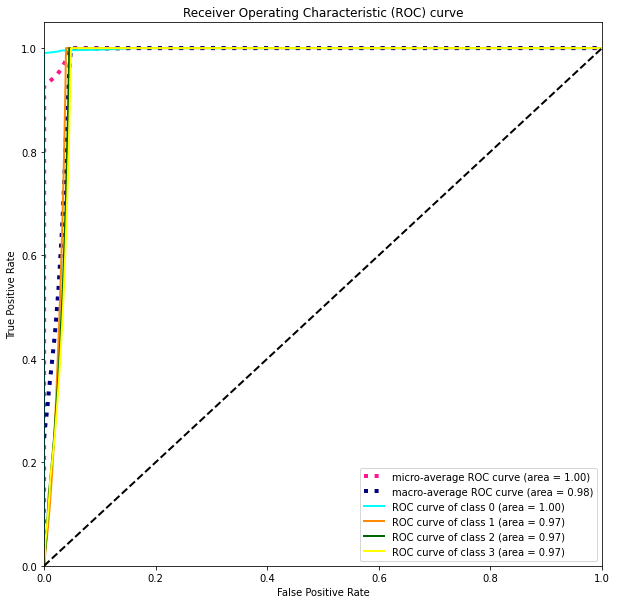

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print("Accuracy : ", accuracy_score(y_test,y_pred))
plot_roc_curve(y_test, y_pred_proba)

Fit and display results of **HistGradientBoostingClassifier** on our data

Accuracy :  0.9023602347863142


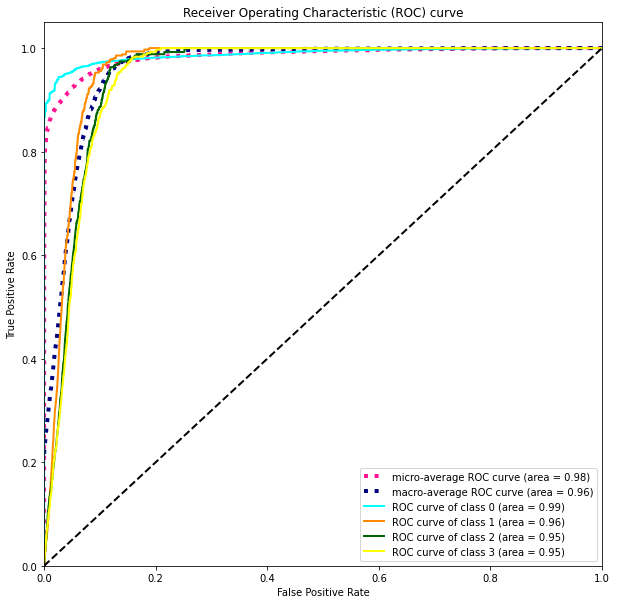

In [17]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

hgb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    random_state=42
)

hgb.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = hgb.predict(X_test)
y_pred_proba = hgb.predict_proba(X_test)

print("Accuracy : ", accuracy_score(y_test,y_pred))
plot_roc_curve(y_test, y_pred_proba)


# Export model

In [19]:
joblib.dump(rf, r"model\random_forest_model.pkl")
joblib.dump(hgb, r"model\HistGradientBoostingClassifier_model.pkl")


['model\\HistGradientBoostingClassifier_model.pkl']